In [1]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)


def get_embedding(text):
    '''Compute GPT3-embedding for a given text string'''
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)


def center_embeddings(df):
    """Offset embeddings by it's center"""
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)


def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x"""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def get_recs(df1, df2, pref='norm', temp=.1, k=3):
    """Normalize df1-df2 proximity and return k best/worst recommendations"""
    # compute preferences
    if pref == 'norm':
        prefs = [[-np.linalg.norm(e1-e2) for e2 in df2.embedding] for e1 in df1.embedding]
    elif pref == 'dot':
        prefs = [[np.dot(e1, e2) for e2 in df2.embedding] for e1 in df1.embedding]
    elif pref == 'cos':
        prefs = [[np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))\
              for e2 in df2.embedding] for e1 in df1.embedding]
    # normalize preferences
    probs = softmax(prefs, temp=temp)
    print(f'probability distribution:\n{probs}')
    
    # show k best/worst recommendations for each element
    inds = probs.argsort(axis=1)
    for i in range(len(df1)):
        print('\n========================\n')
        print(df1.loc[i].content)
        
        # k best recommendations
        print()
        for j in range(k):
            l = inds[i][~j]
            print(f'#{l} ({100*probs[i][l]:2.0f}%): {df2.loc[l].content}')

        # k worst recommendations
        print()
        for j in range(k):
            l = inds[i][j]
            print(f'#{l} ({100*probs[i][l]:2.0f}%): {df2.loc[l].content}')


def visualize_embeddings():
    """Plot a bunch of unnecessary metrics"""
    embs = np.array(people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist())

    # row 1 -- pairwise differences
    fig, ax = plt.subplots(1, 3, figsize=(16,4))

    # plot embedding difference norm
    emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
    im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
    ax[0].set_title('pairwise difference norm')
    ax[0].grid(False)
    plt.colorbar(im0, ax=ax[0])

    # plot embedding cosine similarity
    emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
    im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
    ax[1].set_title('pairwise cosine similarity')
    ax[1].grid(False)
    plt.colorbar(im1, ax=ax[1])

    # plot embedding inner products
    emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
    im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
    ax[2].set_title('pairwise inner products')
    ax[2].grid(False)
    plt.colorbar(im2, ax=ax[2])

    plt.tight_layout()
    plt.show()

    # row 2 -- projection embeddings
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    # plot embedding pca
    emb_pca = PCA(n_components=2).fit_transform(embs)
    people_pca, messages_pca, images_pca = np.split(emb_pca, [len(people),-len(images)])
    # plot people pca
    ax[0].scatter(people_pca[:,0], people_pca[:,1], s=100)
    for ind, pnt in enumerate(people_pca):
        ax[0].annotate(f'  p{ind}', pnt)
    # plot messages pca
    ax[0].scatter(messages_pca[:,0], messages_pca[:,1], s=100)
    for ind, pnt in enumerate(messages_pca):
        ax[0].annotate(f'  m{ind}', pnt)
    # plot images pca
    ax[0].scatter(images_pca[:,0], images_pca[:,1], s=100)
    for ind, pnt in enumerate(images_pca):
        ax[0].annotate(f'  i{ind}', pnt)

    # plot embedding tsne
    emb_tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(embs)
    people_tsne, messages_tsne, images_tsne = np.split(emb_tsne, [len(people),-len(images)])
    # plot people tsne
    ax[1].scatter(people_tsne[:,0], people_tsne[:,1], s=100)
    for ind, pnt in enumerate(people_tsne):
        ax[1].annotate(f'  p{ind}', pnt)
    # plot messages tsne
    ax[1].scatter(messages_tsne[:,0], messages_tsne[:,1], s=100)
    for ind, pnt in enumerate(messages_tsne):
        ax[1].annotate(f'  m{ind}', pnt)
    # plot images tsne
    ax[1].scatter(images_tsne[:,0], images_tsne[:,1], s=100)
    for ind, pnt in enumerate(images_tsne):
        ax[1].annotate(f'  i{ind}', pnt)

    plt.tight_layout()
    plt.show()

### Load content and compute embeddings

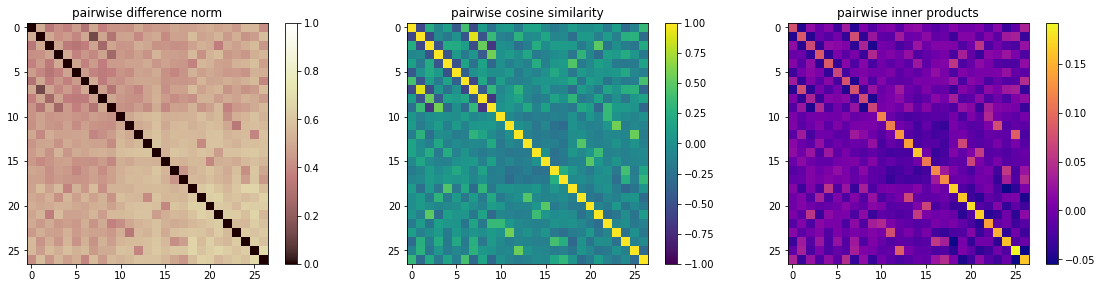

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


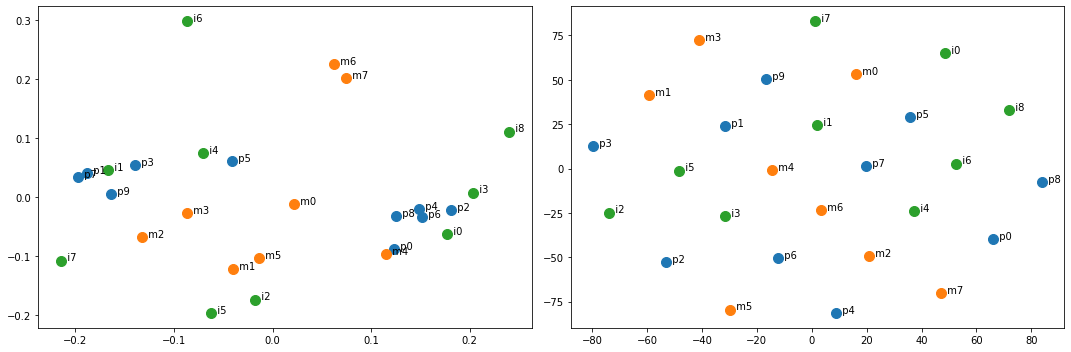

In [2]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

visualize_embeddings()

### Reduce embedding dimensionality

In [3]:
embs_full = np.array(people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist())

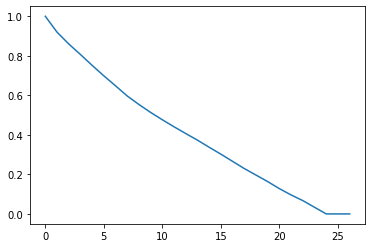

In [4]:
x = np.array(embs_full)
errs = []
for d in range(len(x)):
    pca_proj = PCA(n_components=d)
    y = pca_proj.fit_transform(x)
    z = pca_proj.inverse_transform(y)
    errs.append(np.linalg.norm(x-z))
plt.plot(np.array(errs) / errs[0])
plt.show()

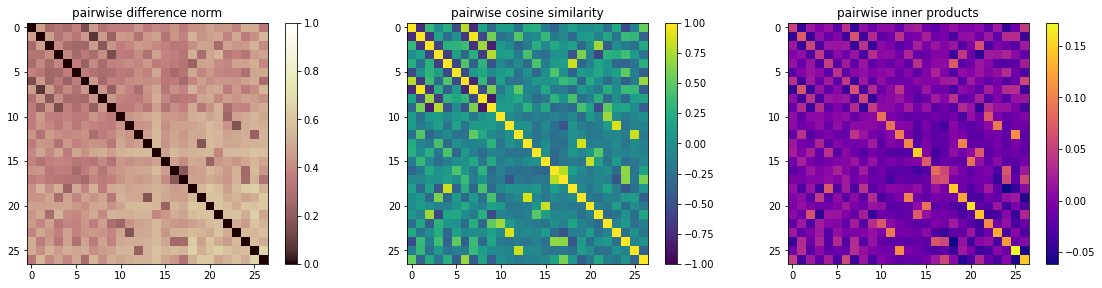

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


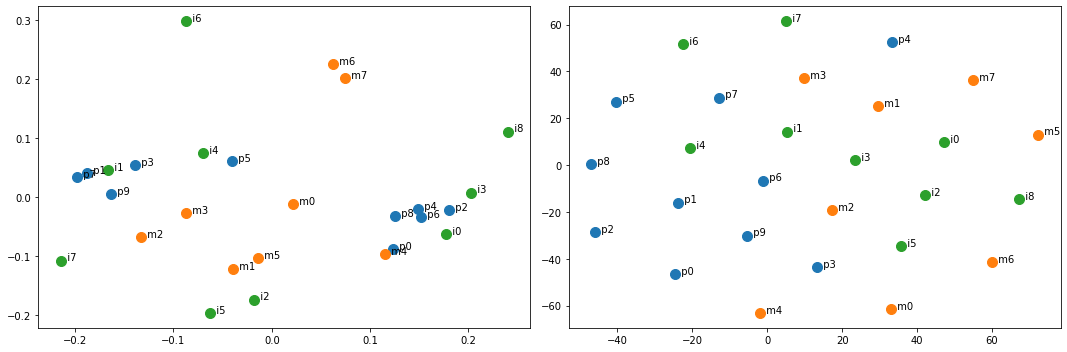

In [5]:
# reduce dimensionality with pca
embs = PCA(n_components=10).fit_transform(embs_full)
# reduce dimensionality with tsne
# embs = TSNE(n_components=10, method='exact', init='pca', learning_rate='auto').fit_transform(embs_full)

people_emb, messages_emb, images_emb = np.split(embs, [len(people),-len(images)])
people.embedding = list(people_emb)
messages.embedding = list(messages_emb)
images.embedding = list(images_emb)

visualize_embeddings()

### Compute recommendations

In [6]:
# people--images
get_recs(people, images, pref='cos', temp=1.)

probability distribution:
[[0.122 0.107 0.104 0.114 0.081 0.133 0.062 0.095 0.182]
 [0.079 0.117 0.119 0.096 0.129 0.086 0.153 0.147 0.074]
 [0.123 0.078 0.105 0.216 0.071 0.104 0.09  0.081 0.132]
 [0.063 0.186 0.089 0.056 0.136 0.129 0.15  0.109 0.08 ]
 [0.24  0.075 0.091 0.123 0.109 0.075 0.072 0.082 0.134]
 [0.074 0.118 0.107 0.131 0.108 0.123 0.176 0.093 0.071]
 [0.137 0.077 0.133 0.103 0.079 0.099 0.071 0.089 0.212]
 [0.077 0.114 0.103 0.089 0.139 0.104 0.154 0.149 0.071]
 [0.165 0.083 0.094 0.141 0.077 0.109 0.079 0.122 0.129]
 [0.075 0.158 0.122 0.061 0.171 0.12  0.124 0.101 0.07 ]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#8 (18%): Young adult African American man walking his dog in the park.
#5 (13%): Person coloring in a coloring book with crayons.
#0 (12%): Young adult Indian man playing guitar and smiling.

#6 ( 6%): Senior white woman biking in the park and loo

In [7]:
# messages--images
get_recs(messages, images, pref='cos', temp=1.)

probability distribution:
[[0.099 0.079 0.115 0.096 0.214 0.103 0.09  0.098 0.107]
 [0.108 0.088 0.083 0.09  0.111 0.251 0.082 0.094 0.093]
 [0.107 0.1   0.087 0.088 0.097 0.098 0.088 0.246 0.088]
 [0.104 0.251 0.09  0.09  0.09  0.1   0.084 0.101 0.09 ]
 [0.117 0.102 0.115 0.178 0.091 0.1   0.097 0.103 0.097]
 [0.091 0.086 0.241 0.118 0.084 0.113 0.082 0.086 0.098]
 [0.118 0.101 0.086 0.097 0.104 0.078 0.208 0.083 0.124]
 [0.098 0.091 0.09  0.096 0.093 0.064 0.197 0.084 0.188]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (21%): Young adult asian woman reading a book outside and smiling.
#2 (12%): Person with glasses filling out the newspaper crossword puzzle.
#8 (11%): Young adult African American man walking his dog in the park.

#1 ( 8%): Adult white woman rolling dough in the kitchen and smiling.
#6 ( 9%): Senior white woman biking in the park and looking toward

In [8]:
# people--messages
get_recs(people, messages, pref='cos', temp=1.)

probability distribution:
[[0.139 0.137 0.095 0.156 0.161 0.105 0.088 0.117]
 [0.094 0.104 0.192 0.109 0.118 0.169 0.101 0.112]
 [0.134 0.119 0.088 0.105 0.16  0.114 0.153 0.127]
 [0.133 0.14  0.102 0.185 0.099 0.094 0.122 0.126]
 [0.118 0.098 0.12  0.09  0.191 0.107 0.135 0.14 ]
 [0.129 0.14  0.093 0.122 0.087 0.121 0.189 0.119]
 [0.139 0.098 0.095 0.108 0.133 0.124 0.128 0.176]
 [0.099 0.133 0.2   0.11  0.106 0.15  0.101 0.103]
 [0.124 0.133 0.149 0.112 0.092 0.099 0.164 0.126]
 [0.136 0.136 0.114 0.164 0.112 0.151 0.09  0.097]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#4 (16%): Put down your phone and shuffle the deck! Solitaire is a classic card game that's perfect for passing the time and challenging your mind. Let's get playing!
#3 (16%): Put down your phone and preheat the oven! Baking is a fun and creative way to satisfy your sweet tooth and impress your friends and

### Option 1: Remove dislikes

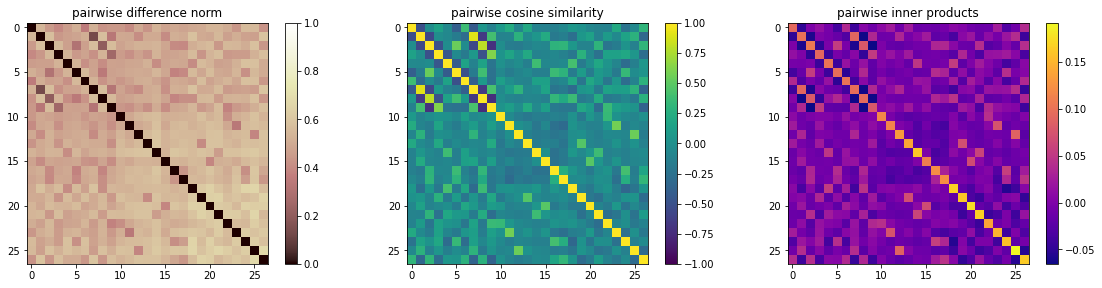

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


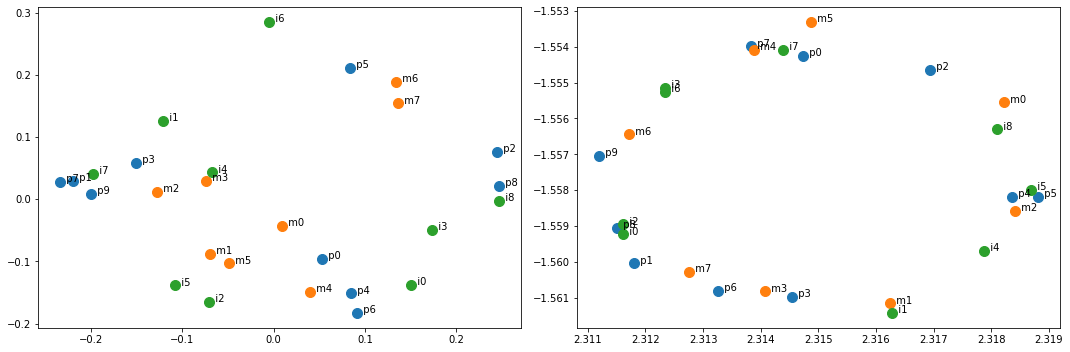

In [9]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

# remove dislikes
people.content = people.content.apply(lambda p: p.split('\nDislikes: ')[0])

# compute embeddings
for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

visualize_embeddings()

In [10]:
get_recs(people, messages, pref='norm', temp=.1)

probability distribution:
[[0.154 0.228 0.089 0.169 0.061 0.106 0.09  0.103]
 [0.098 0.103 0.225 0.089 0.09  0.231 0.078 0.086]
 [0.114 0.086 0.069 0.072 0.064 0.106 0.24  0.25 ]
 [0.138 0.199 0.113 0.175 0.063 0.114 0.104 0.094]
 [0.134 0.111 0.108 0.076 0.239 0.12  0.102 0.11 ]
 [0.1   0.085 0.079 0.083 0.054 0.093 0.278 0.228]
 [0.18  0.132 0.091 0.082 0.119 0.198 0.094 0.104]
 [0.108 0.164 0.229 0.084 0.073 0.193 0.071 0.077]
 [0.117 0.103 0.081 0.08  0.063 0.101 0.261 0.194]
 [0.136 0.172 0.105 0.172 0.07  0.184 0.083 0.078]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting

#1 (23%): Put down your phone and grab some colored pencils! Coloring books are a fun and creative way to unwind and unleash your inner artist. Let's get coloring!
#3 (17%): Put down your phone and preheat the oven! Baking is a fun and creative way to satisfy your sweet tooth and impress your friends and family. Let's get baking!
#0 (15%): P

In [11]:
get_recs(people, images, pref='norm', temp=.1)

probability distribution:
[[0.109 0.104 0.072 0.073 0.099 0.197 0.06  0.063 0.224]
 [0.051 0.116 0.129 0.072 0.161 0.102 0.155 0.167 0.047]
 [0.107 0.076 0.065 0.215 0.074 0.077 0.108 0.055 0.225]
 [0.057 0.197 0.072 0.051 0.173 0.158 0.161 0.081 0.05 ]
 [0.286 0.062 0.081 0.148 0.131 0.087 0.049 0.05  0.105]
 [0.064 0.126 0.059 0.114 0.129 0.075 0.256 0.07  0.107]
 [0.159 0.059 0.147 0.108 0.078 0.129 0.053 0.056 0.211]
 [0.045 0.107 0.103 0.063 0.182 0.152 0.141 0.163 0.042]
 [0.239 0.063 0.061 0.164 0.077 0.075 0.081 0.046 0.193]
 [0.055 0.147 0.102 0.048 0.281 0.143 0.111 0.072 0.041]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting

#8 (22%): Young adult African American man walking his dog in the park.
#5 (20%): Person coloring in a coloring book with crayons.
#0 (11%): Young adult Indian man playing guitar and smiling.

#6 ( 6%): Senior white woman biking in the park and looking towards the sky.
#7 ( 6%): Per

In [12]:
get_recs(messages, images, pref='norm', temp=.1)

probability distribution:
[[0.095 0.062 0.098 0.075 0.312 0.117 0.088 0.058 0.097]
 [0.076 0.062 0.047 0.053 0.106 0.499 0.054 0.047 0.056]
 [0.08  0.087 0.059 0.058 0.095 0.082 0.072 0.412 0.056]
 [0.084 0.388 0.062 0.062 0.089 0.108 0.071 0.073 0.064]
 [0.111 0.084 0.101 0.305 0.089 0.088 0.072 0.063 0.087]
 [0.069 0.072 0.349 0.1   0.091 0.116 0.07  0.056 0.077]
 [0.097 0.075 0.051 0.082 0.124 0.064 0.314 0.046 0.146]
 [0.081 0.089 0.067 0.093 0.118 0.058 0.2   0.052 0.243]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (31%): Young adult asian woman reading a book outside and smiling.
#5 (12%): Person coloring in a coloring book with crayons.
#2 (10%): Person with glasses filling out the newspaper crossword puzzle.

#7 ( 6%): Person knitting at home next to a basket of yarn.
#1 ( 6%): Adult white woman rolling dough in the kitchen and smiling.
#3 ( 7%): Senior hi

### Option 2: Embed people differently

In [222]:
def get_embedding_people(person):
    """Compute embeddings accounting for likes and dislikes"""
    demographics, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')
    return get_embedding(demographics)


def include_interests(people):
    """Adjust embeddings for likes and dislikes"""
    for i in range(len(people)):
        person = people.loc[i].content
        _, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')

        # positively adjust for likes
        for hobby in likes.split(', '):
            people.loc[i].embedding += .2 * get_embedding(hobby)

        # negatively adjust for dislikes
        for hobby in dislikes.split(', '):
            people.loc[i].embedding -= .2 * get_embedding(hobby)

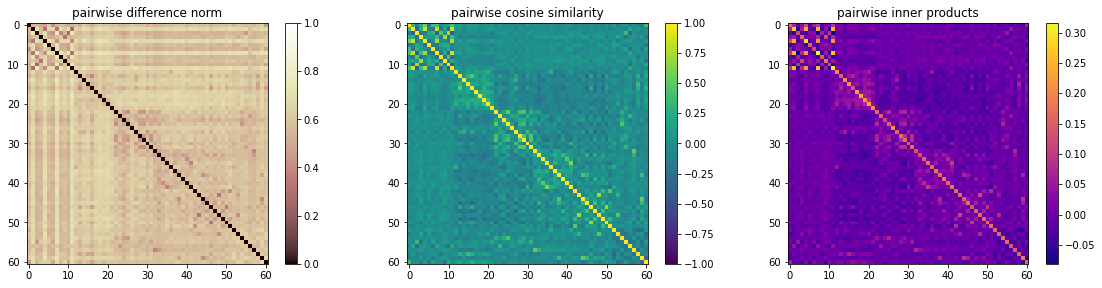

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


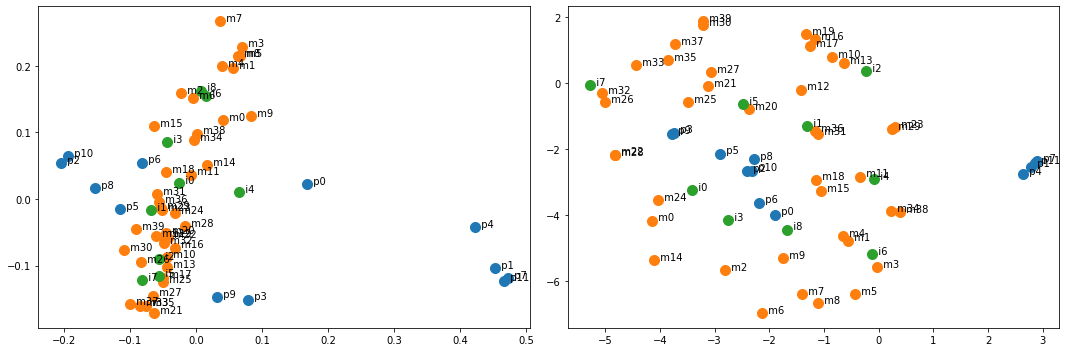

In [223]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

for df in [messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

# compute demographic embeddings
people['embedding'] = people['content'].apply(get_embedding_people)
center_embeddings(people)

# adjust for people's interests
include_interests(people)

visualize_embeddings()

In [224]:
get_recs(people, messages, pref='norm', temp=.1)

probability distribution:
[[0.025 0.04  0.014 0.022 0.047 0.021 0.012 0.018 0.016 0.022 0.02  0.034
  0.033 0.025 0.017 0.023 0.023 0.023 0.044 0.024 0.038 0.03  0.026 0.022
  0.027 0.019 0.019 0.018 0.031 0.027 0.019 0.023 0.027 0.02  0.035 0.025
  0.024 0.02  0.028 0.017]
 [0.023 0.038 0.016 0.025 0.039 0.022 0.014 0.019 0.02  0.03  0.027 0.029
  0.034 0.028 0.022 0.019 0.026 0.024 0.024 0.024 0.031 0.033 0.028 0.02
  0.023 0.022 0.022 0.021 0.032 0.019 0.02  0.023 0.028 0.021 0.035 0.024
  0.024 0.022 0.029 0.018]
 [0.017 0.026 0.014 0.015 0.031 0.014 0.011 0.015 0.012 0.012 0.026 0.029
  0.048 0.031 0.015 0.03  0.024 0.025 0.039 0.028 0.033 0.035 0.03  0.024
  0.025 0.018 0.026 0.021 0.027 0.028 0.029 0.035 0.025 0.022 0.03  0.026
  0.03  0.029 0.022 0.024]
 [0.021 0.018 0.015 0.014 0.02  0.013 0.011 0.012 0.011 0.012 0.021 0.023
  0.04  0.025 0.018 0.022 0.022 0.022 0.036 0.02  0.042 0.043 0.033 0.029
  0.026 0.031 0.031 0.029 0.027 0.031 0.026 0.026 0.041 0.034 0.024 0.034
  0.03

In [16]:
get_recs(people, images, pref='norm', temp=.1)

probability distribution:
[[0.119 0.08  0.086 0.072 0.091 0.143 0.062 0.063 0.283]
 [0.061 0.128 0.106 0.076 0.194 0.124 0.156 0.112 0.045]
 [0.126 0.075 0.087 0.236 0.072 0.091 0.089 0.065 0.158]
 [0.067 0.199 0.095 0.051 0.152 0.147 0.145 0.094 0.05 ]
 [0.183 0.082 0.095 0.095 0.174 0.127 0.06  0.076 0.107]
 [0.084 0.138 0.077 0.138 0.124 0.094 0.177 0.088 0.08 ]
 [0.129 0.072 0.134 0.105 0.074 0.144 0.056 0.071 0.217]
 [0.057 0.125 0.09  0.069 0.214 0.145 0.153 0.104 0.043]
 [0.169 0.063 0.088 0.225 0.078 0.085 0.074 0.049 0.17 ]
 [0.069 0.139 0.086 0.045 0.305 0.121 0.111 0.084 0.041]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#8 (28%): Young adult African American man walking his dog in the park.
#5 (14%): Person coloring in a coloring book with crayons.
#0 (12%): Young adult Indian man playing guitar and smiling.

#6 ( 6%): Senior white woman biking in the park and loo

In [17]:
get_recs(messages, images, pref='norm', temp=.1)

probability distribution:
[[0.095 0.062 0.098 0.075 0.312 0.117 0.088 0.058 0.097]
 [0.076 0.062 0.047 0.053 0.106 0.499 0.054 0.047 0.056]
 [0.08  0.087 0.059 0.058 0.095 0.082 0.072 0.411 0.056]
 [0.084 0.388 0.062 0.062 0.089 0.108 0.071 0.073 0.064]
 [0.111 0.084 0.1   0.305 0.09  0.088 0.072 0.063 0.087]
 [0.069 0.073 0.349 0.1   0.091 0.116 0.07  0.056 0.077]
 [0.097 0.076 0.051 0.082 0.124 0.064 0.313 0.046 0.147]
 [0.081 0.089 0.067 0.093 0.118 0.058 0.2   0.052 0.242]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (31%): Young adult asian woman reading a book outside and smiling.
#5 (12%): Person coloring in a coloring book with crayons.
#2 (10%): Person with glasses filling out the newspaper crossword puzzle.

#7 ( 6%): Person knitting at home next to a basket of yarn.
#1 ( 6%): Adult white woman rolling dough in the kitchen and smiling.
#3 ( 7%): Senior hi

## Recommending tuples (person, image, message)

In [228]:
def get_recs_tuple(pref='norm', temp=.1, k=5):
    """Normalize (person,message,image) proximity and return k best/worst recommendations"""
    num_messages = len(messages)
    num_images = len(images)

    # compute normalized preferences
    people_prefs = []
    for p, person_emb in enumerate(people.embedding):
        prefs = np.zeros((num_messages, num_images))
        for i, message_emb in enumerate(messages.embedding):
            for j, image_emb in enumerate(images.embedding):
                prefs[i][j] = np.linalg.norm(person_emb - message_emb)\
                            + np.linalg.norm(person_emb - image_emb)\
                            + np.linalg.norm(message_emb - image_emb)
        probs = softmax(-prefs.reshape(1,-1), temp=temp).reshape(num_messages, num_images)
        people_prefs.append(probs)
        print(probs)

        # show k best recommendations for each person
        print(f'\n{people.loc[p].content}\n')
        for ii, jj in zip(*np.unravel_index(np.argsort(probs, axis=None)[-1:-k-1:-1], probs.shape)):
            print(f'#{jj}/#{ii} ({100*probs[ii][jj]:2.0f}%): '\
                  + f'{images.loc[jj].content}\n{messages.loc[ii].content}\n')
        print('\n================================================\n')

    return people_prefs

In [102]:
prefs = get_recs_tuple()

[[0.014 0.008 0.011 0.007 0.043 0.026 0.008 0.005 0.03 ]
 [0.018 0.012 0.008 0.007 0.023 0.17  0.007 0.007 0.027]
 [0.008 0.007 0.004 0.003 0.009 0.012 0.004 0.025 0.011]
 [0.011 0.04  0.006 0.004 0.01  0.02  0.005 0.006 0.016]
 [0.004 0.002 0.003 0.006 0.003 0.004 0.001 0.001 0.006]
 [0.008 0.007 0.032 0.007 0.01  0.021 0.005 0.004 0.019]
 [0.01  0.006 0.004 0.005 0.012 0.01  0.019 0.003 0.031]
 [0.009 0.008 0.006 0.006 0.012 0.01  0.013 0.004 0.056]]

Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#5/#1 (17%): Person coloring in a coloring book with crayons.
Put down your phone and grab some colored pencils! Coloring books are a fun and creative way to unwind and unleash your inner artist. Let's get coloring!

#8/#7 ( 6%): Young adult African American man walking his dog in the park.
Put down your phone and lace up your shoes! Walking is a great way to get some fresh air, clear y

## Alternative way of adjusting for interests (Anton's idea)

In [243]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')
interests = pd.read_csv('./data/interests.csv')

for df in [messages, images, interests]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

# compute demographic embeddings
people['embedding'] = people['content'].apply(get_embedding_people)
center_embeddings(people)

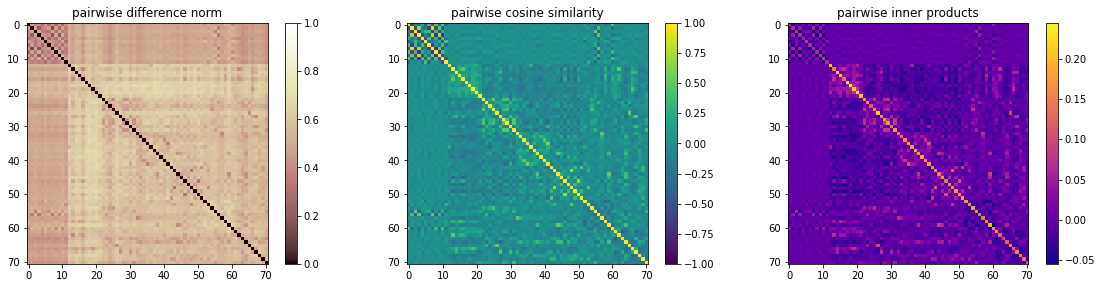

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


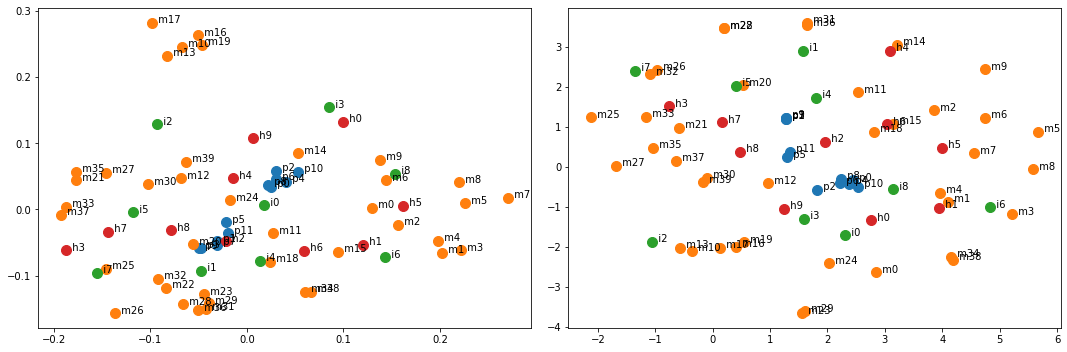

In [244]:
embs = np.array(people.embedding.tolist()\
              + messages.embedding.tolist()\
              + images.embedding.tolist()\
              + interests.embedding.tolist())

# row 1 -- pairwise differences
fig, ax = plt.subplots(1, 3, figsize=(16,4))

# plot embedding difference norm
emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# plot embedding cosine similarity
emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

# plot embedding inner products
emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
ax[2].set_title('pairwise inner products')
ax[2].grid(False)
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()

# row 2 -- projection embeddings
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot embedding pca
emb_pca = PCA(n_components=2).fit_transform(embs)
people_pca, messages_pca, images_pca, interests_pca =\
    np.split(emb_pca, [len(people), len(people)+len(messages), len(people)+len(messages)+len(images)])
# plot people pca
ax[0].scatter(people_pca[:,0], people_pca[:,1], s=100)
for ind, pnt in enumerate(people_pca):
    ax[0].annotate(f'  p{ind}', pnt)
# plot messages pca
ax[0].scatter(messages_pca[:,0], messages_pca[:,1], s=100)
for ind, pnt in enumerate(messages_pca):
    ax[0].annotate(f'  m{ind}', pnt)
# plot images pca
ax[0].scatter(images_pca[:,0], images_pca[:,1], s=100)
for ind, pnt in enumerate(images_pca):
    ax[0].annotate(f'  i{ind}', pnt)
# plot interests pca
ax[0].scatter(interests_pca[:,0], interests_pca[:,1], s=100)
for ind, pnt in enumerate(interests_pca):
    ax[0].annotate(f'  h{ind}', pnt)

# plot embedding tsne
emb_tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(embs)
people_tsne, messages_tsne, images_tsne, interests_tsne =\
    np.split(emb_tsne, [len(people), len(people)+len(messages), len(people)+len(messages)+len(images)])
# plot people tsne
ax[1].scatter(people_tsne[:,0], people_tsne[:,1], s=100)
for ind, pnt in enumerate(people_tsne):
    ax[1].annotate(f'  p{ind}', pnt)
# plot messages tsne
ax[1].scatter(messages_tsne[:,0], messages_tsne[:,1], s=100)
for ind, pnt in enumerate(messages_tsne):
    ax[1].annotate(f'  m{ind}', pnt)
# plot images tsne
ax[1].scatter(images_tsne[:,0], images_tsne[:,1], s=100)
for ind, pnt in enumerate(images_tsne):
    ax[1].annotate(f'  i{ind}', pnt)
# plot interests tsne
ax[1].scatter(interests_tsne[:,0], interests_tsne[:,1], s=100)
for ind, pnt in enumerate(interests_tsne):
    ax[1].annotate(f'  h{ind}', pnt)

plt.tight_layout()
plt.show()

In [247]:
hobbies = {}
for i in range(len(interests)):
    hobbies[interests.loc[i].interest] = interests.loc[i].embedding

In [248]:
hobbies

{'Sports': array([-0.006, -0.007,  0.009, ..., -0.021, -0.005,  0.003]),
 'Outdoors': array([ 0.018,  0.001, -0.003, ...,  0.001, -0.012, -0.006]),
 'Indoors': array([ 0.009, -0.001, -0.001, ...,  0.007, -0.004, -0.005]),
 'Arts and Crafts': array([-0.015, -0.004, -0.015, ...,  0.021,  0.01 , -0.005]),
 'Learning': array([ 0.001,  0.001,  0.009, ..., -0.006,  0.003,  0.013]),
 'Exercise': array([-0.009, -0.006, -0.001, ...,  0.007,  0.006,  0.007]),
 'Relaxing': array([-0.001,  0.015,  0.024, ...,  0.004,  0.001,  0.011]),
 'Design': array([ 0.018,  0.004, -0.006, ..., -0.001, -0.005, -0.005]),
 'Homemaking': array([ 0.005, -0.011, -0.021, ...,  0.008,  0.007, -0.003]),
 'Games': array([-0.02 ,  0.008,  0.005, ..., -0.019, -0.002, -0.01 ])}

In [252]:
def include_hobbies(people):
    """Adjust embeddings for likes and dislikes"""
    for i in range(len(people)):
        person = people.loc[i].content
        _, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')

        # positively adjust for likes
        for hobby in likes.split(', '):
            people.loc[i].embedding += .2 * hobbies[hobby]

        # negatively adjust for dislikes
        for hobby in dislikes.split(', '):
            people.loc[i].embedding -= .2 * hobbies[hobby]

In [253]:
people

,content,embedding
0,Gender: Male\nAge: Young Adult\nRace: African ...,"[-0.000831215487172206, -0.006500478576829967,..."
1,Gender: Female\nAge: Adult\nRace: Asian\nLifes...,"[-0.004450410449256499, 0.00466920461137003, 0..."
2,Gender: Male\nAge: Senior\nRace: Hispanic\nLif...,"[0.004821806137139599, 0.0003398831710607435, ..."
3,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.004787808128943046, 0.002645995666777405, ..."
4,Gender: Male\nAge: Adult\nRace: White\nLifesty...,"[0.0036089694282660885, -0.004639127965977726,..."
5,Gender: Female\nAge: Middle-aged\nRace: Hispan...,"[-0.0023604033825298147, 0.01908042028177685, ..."
6,Gender: Male\nAge: Senior\nRace: White\nLifest...,"[0.002549629348019759, -0.012201185081115304, ..."
7,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.006653510810186465, 0.0037797615174592165,..."
8,Gender: Male\nAge: Adult\nRace: African Americ...,"[0.008102880946050089, -0.0057644967212884994,..."
9,Gender: Female\nAge: Middle-aged\nRace: Asian\...,"[-0.001956826852013667, 0.00822873299572772, 0..."


In [254]:
include_hobbies(people)

In [255]:
people

,content,embedding
0,Gender: Male\nAge: Young Adult\nRace: African ...,"[-0.0011171552895878753, -0.009385339961348412..."
1,Gender: Female\nAge: Adult\nRace: Asian\nLifes...,"[0.000957794735829036, -0.0045692055476441356,..."
2,Gender: Male\nAge: Senior\nRace: Hispanic\nLif...,"[2.6784107709925797e-05, 0.0016252669515476248..."
3,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.011246222405073544, 0.004912948458028648, ..."
4,Gender: Male\nAge: Adult\nRace: White\nLifesty...,"[-0.0009589705461015301, -0.006123096774293419..."
5,Gender: Female\nAge: Middle-aged\nRace: Hispan...,"[-0.007155425411959489, 0.020365804062263734, ..."
6,Gender: Male\nAge: Senior\nRace: White\nLifest...,"[0.0014234243348861732, -0.004363667498303889,..."
7,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.0012453056251009295, -0.005458648641554949..."
8,Gender: Male\nAge: Adult\nRace: African Americ...,"[0.003307858916620415, -0.004479112940801618, ..."
9,Gender: Female\nAge: Middle-aged\nRace: Asian\...,"[-0.008415241128144166, 0.010495685786978962, ..."


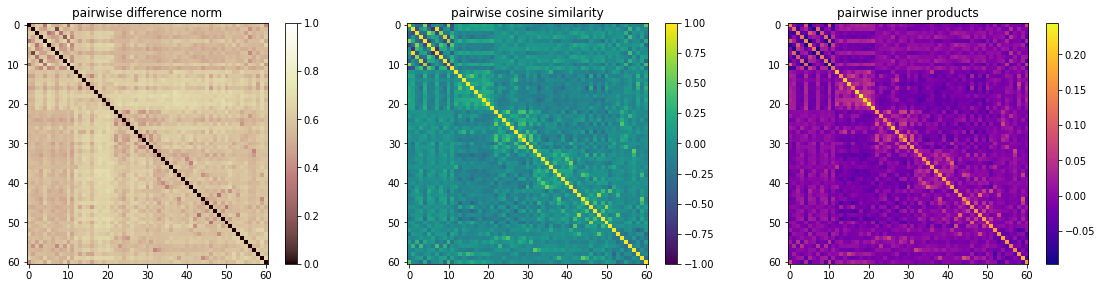

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


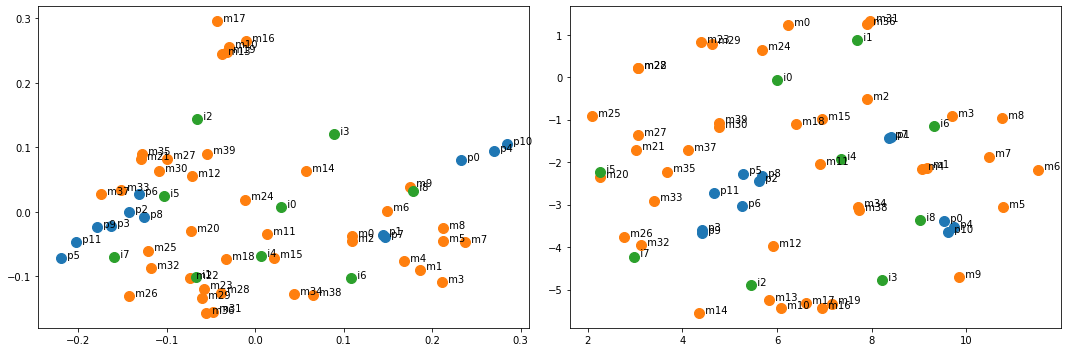

In [256]:
visualize_embeddings()

In [257]:
get_recs(people, messages, k=5, pref='norm', temp=.1)

probability distribution:
[[0.023 0.051 0.02  0.024 0.053 0.027 0.021 0.034 0.022 0.028 0.024 0.038
  0.028 0.03  0.026 0.025 0.03  0.026 0.028 0.024 0.026 0.025 0.02  0.021
  0.025 0.016 0.015 0.019 0.023 0.02  0.016 0.02  0.019 0.018 0.034 0.023
  0.019 0.014 0.027 0.017]
 [0.021 0.047 0.024 0.031 0.043 0.023 0.019 0.026 0.022 0.029 0.027 0.025
  0.032 0.027 0.021 0.022 0.023 0.023 0.018 0.018 0.024 0.028 0.024 0.018
  0.025 0.019 0.019 0.02  0.03  0.017 0.025 0.028 0.022 0.02  0.037 0.022
  0.028 0.019 0.03  0.026]
 [0.016 0.019 0.014 0.012 0.025 0.011 0.01  0.012 0.01  0.01  0.025 0.026
  0.052 0.029 0.014 0.033 0.022 0.022 0.041 0.03  0.036 0.033 0.03  0.022
  0.026 0.017 0.028 0.02  0.022 0.03  0.042 0.032 0.039 0.025 0.029 0.03
  0.029 0.032 0.019 0.027]
 [0.015 0.015 0.013 0.011 0.016 0.01  0.008 0.01  0.01  0.015 0.025 0.03
  0.04  0.028 0.03  0.018 0.026 0.027 0.027 0.026 0.032 0.049 0.029 0.028
  0.021 0.039 0.035 0.026 0.027 0.022 0.021 0.026 0.045 0.04  0.025 0.037
  0.026

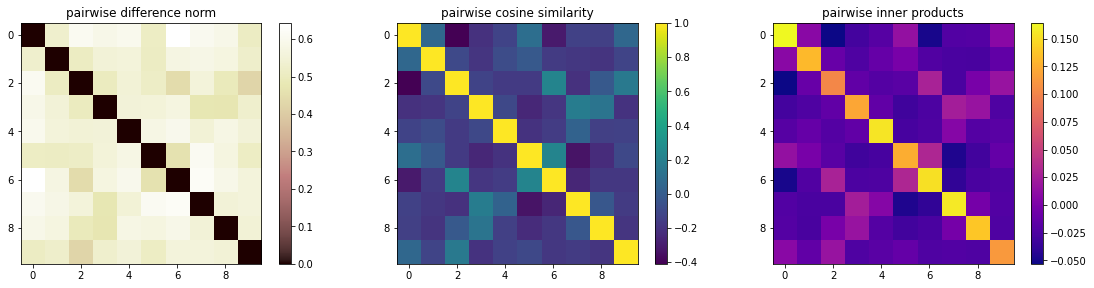

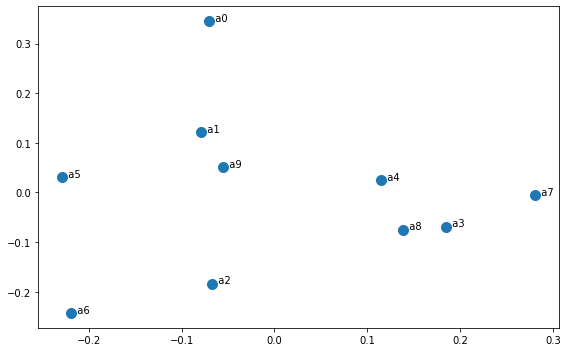

In [268]:
embs = np.array(interests.embedding.tolist())


# row 1 -- pairwise differences
fig, ax = plt.subplots(1, 3, figsize=(16,4))

# plot embedding difference norm
emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
im0 = ax[0].imshow(emb_norm_diff, cmap='pink')#, vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# plot embedding cosine similarity
emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
im1 = ax[1].imshow(emb_cossim, cmap='viridis')#, vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

# plot embedding inner products
emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
ax[2].set_title('pairwise inner products')
ax[2].grid(False)
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8,5))
emb_pca = PCA(n_components=2).fit_transform(embs)
ax.scatter(emb_pca[:,0], emb_pca[:,1], s=100)
for ind, pnt in enumerate(emb_pca):
    ax.annotate(f'  a{ind}', pnt)
plt.tight_layout()
plt.show()

In [267]:
interests

,content,interest,embedding
0,"Physical activities that involve competition, ...",Sports,"[-0.005762184306513518, -0.0069091924116946755..."
1,"Activities that take place outside, such as hi...",Outdoors,"[0.01834712802665308, 0.0010002508177421989, -..."
2,"Activities that take place inside, such as rea...",Indoors,"[0.00930481703253463, -0.0014485580497421323, ..."
3,Activities that involve creating something by ...,Arts and Crafts,"[-0.015070830739568919, -0.00407593963900581, ..."
4,Activities that involve acquiring new knowledg...,Learning,"[0.0011149571160785853, 0.001273888524156064, ..."
5,Physical activities that involve movement and ...,Exercise,"[-0.008919636986684054, -0.005991997069213539,..."
6,Activities that promote relaxation and stress ...,Relaxing,"[-0.0012768172076903284, 0.01506958914687857, ..."
7,Activities that involve creating or improving ...,Design,"[0.017912291653919964, 0.003911359247285873, -..."
8,Activities that involve managing and maintaini...,Homemaking,"[0.004645319154951722, -0.011107751971576364, ..."
9,"Activities that involve playing games, such as...",Games,"[-0.020295043743681164, 0.008278351405169814, ..."
